# Data Analysis

Approach:

    Preprocess Images: Convert them to grayscale, normalize, and subtract the baseline from the active image.
    Segment Active Regions: Use OpenCV or a deep learning model to detect the highlighted brain regions.
    Identify the Region: Use a pre-trained model (e.g., a convolutional neural network trained on brain MRI scans) or a simple region-based lookup to determine which part of the brain is active.
    Overlay Annotations: Draw text labels or bounding boxes on the image.

## Imports, Settings, & Function Definitions

In [1]:
from moviepy import VideoFileClip
import librosa
from IPython.display import Audio as IPDAudio
from IPython.display import display, Image, Video
from transformers import pipeline
from datasets import Audio as Datasets_Audio
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.metrics import accuracy_score
import cv2
import time
from glob import glob
import os
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as tv_datasets
import torchvision.models as models

from PIL import Image as PIL_Image
import shutil
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import random_split

import ipywidgets as widgets
import sounddevice as sd
import wave

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
def extract_audio_from_video(video_file_path, audio_output_path):
    """
    This function will accept a video file path and output
    the extracted audio.

    Parameters
    ----------
    video_file_path : string
        This is the path to the mp4 video.
    audio_output_path : string
        This is the path to the output audio wav file.
    """
    video = VideoFileClip(video_file_path)
    audio = video.audio
    audio.write_audiofile(audio_output_path)

In [3]:
# Define the function to extract MFCC features
def extract_mfcc(audio_path, sr=22050, n_mfcc=40, max_len=50):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to max_len
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

In [4]:
# Save the model state_dict
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [5]:
# Define CNN Model
class NeuralDataExpert(nn.Module):
    def __init__(self):
        super(NeuralDataExpert, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Binary classification (Laughter vs. Non-Laughter)
        self.brain_modality_mean = [17.6743, 17.4406, 17.1653]
        self.brain_modality_std = [7.7531, 8.4884, 9.5815]
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
                transforms.Normalize(mean=self.brain_modality_mean, std=self.brain_modality_std)
        ])
    
    def forward(self, x):
        return self.model(x)

In [6]:
class SingleImageDataset(Dataset):
    def __init__(self, image_path, label, transform=None):
        """
        Args:
            image_path (str): Path to the image file.
            label (int): Label for the image.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.image_path = image_path
        self.label = label
        self.transform = transform

        # Load image
        self.image = PIL_Image.open(self.image_path).convert("RGB")

    def __len__(self):
        # Since it's just one image, the dataset length is 1
        return 1

    def __getitem__(self, idx):
        # Apply transformation if provided
        if self.transform:
            image = self.transform(self.image)
        else:
            image = self.image

        label = torch.tensor(self.label, dtype=torch.long)  # Or float if needed
        return image, label


In [7]:
class AudioClassifier(nn.Module):
    def __init__(self, n_mfcc=40, max_len=96):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Compute the output size after pooling
        fc_input_size = 32 * (n_mfcc // 4) * (max_len // 4)  # 2 pooling layers divide by 4
        
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [8]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, sr=22050, n_mfcc=40, max_len=50):
        self.root_dir = root_dir
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        self.audio_paths = []
        self.labels = []

        # Assign labels based on folder names
        self.label_map = {"laughter-only": 1, "non-laughter": 0}

        for label_name in self.label_map.keys():
            label_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        file_path = os.path.join(label_path, file_name)
                        self.audio_paths.append(file_path)
                        self.labels.append(self.label_map[label_name])

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = torch.tensor(float(self.labels[idx]), dtype=torch.float32)  # BCELoss needs float labels

        # Extract MFCC features and convert to tensor
        mfcc = extract_mfcc(audio_path, sr=self.sr, n_mfcc=self.n_mfcc, max_len=self.max_len)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return mfcc_tensor, label


In [9]:
# Expert Networks (one for each modality)
# class AudioExpert(nn.Module):
#     def __init__(self):
#         super(AudioExpert, self).__init__()
#         self.fc = nn.Linear(256, 256)

#     def forward(self, x):
#         return self.fc(x)


class FacialEmotionExpert(nn.Module):
    def __init__(self):
        super(FacialEmotionExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class BodyPoseExpert(nn.Module):
    def __init__(self):
        super(BodyPoseExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


# class NeuralDataExpert(nn.Module):
#     def __init__(self):
#         super(NeuralDataExpert, self).__init__()
#         self.fc = nn.Linear(256, 256)

#     def forward(self, x):
#         return self.fc(x)



# Gating Network (Decides how much weight each expert gets)
class GatingNetwork(nn.Module):
    def __init__(self):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(1024, 4)  # 4 experts (one per modality)

    def forward(self, x):
        gate_weights = F.softmax(self.fc(x), dim=1)  # Output weights for each expert
        return gate_weights


# MoE Model that uses Gating Network and Expert Networks
class MixtureOfExperts(nn.Module):
    def __init__(self):
        super(MixtureOfExperts, self).__init__()
        self.audio_expert = AudioClassifier()
        self.facial_emotion_expert = FacialEmotionExpert()
        self.body_pose_expert = BodyPoseExpert()
        self.neural_data_expert = NeuralDataExpert()
        self.gating_network = GatingNetwork()
        self.final_fc = nn.Linear(256, 1)

    def forward(
        self,
        audio,
        facial_emotion,
        body_pose,
        neural_data,
        audio_labels,
        facial_labels,
        body_pose_labels,
        neural_labels,
    ):
        # Concatenate inputs to pass through the gating network
        combined_input = torch.cat(
            (audio, facial_emotion, body_pose, neural_data), dim=1
        )

        # Get gate weights (importance of each modality)
        gate_weights = self.gating_network(combined_input)

        # Compute the output of each expert
        audio_output = self.audio_expert(audio)
        facial_emotion_output = self.facial_emotion_expert(facial_emotion)
        body_pose_output = self.body_pose_expert(body_pose)
        neural_data_output = self.neural_data_expert(neural_data)

        # Combine the outputs weighted by the gate's output
        weighted_outputs = (
            gate_weights[:, 0].unsqueeze(1) * audio_output
            + gate_weights[:, 1].unsqueeze(1) * facial_emotion_output
            + gate_weights[:, 2].unsqueeze(1) * body_pose_output
            + gate_weights[:, 3].unsqueeze(1) * neural_data_output
        )

        final_output = self.final_fc(weighted_outputs)

        # Sigmoid activation to get probability
        prediction = torch.sigmoid(final_output)

        # Compute individual modality losses (e.g., binary cross-entropy for each modality)
        audio_loss = nn.BCELoss()(audio_output, audio_labels)
        facial_loss = nn.BCELoss()(facial_emotion_output, facial_labels)
        body_pose_loss = nn.BCELoss()(body_pose_output, body_pose_labels)
        neural_loss = nn.BCELoss()(neural_data_output, neural_labels)

        # Combine the losses
        total_loss = audio_loss + facial_loss + body_pose_loss + neural_loss

        return prediction, total_loss


In [10]:
class MultiModalDataset(Dataset):
    def __init__(
        self,
        audio_data,
        facial_data,
        body_pose_data,
        neural_data,
        audio_labels,
        facial_labels,
        body_pose_labels,
        neural_labels,
    ):
        self.audio_data = audio_data  # (N, audio_feature_size)
        self.facial_data = facial_data  # (N, facial_feature_size)
        self.body_pose_data = body_pose_data  # (N, pose_feature_size)
        self.neural_data = neural_data  # (N, neural_feature_size)

        # Modality-specific labels
        self.audio_labels = audio_labels  # (N, 1) for audio classification
        self.facial_labels = facial_labels  # (N, 1) for facial emotion classification
        self.body_pose_labels = body_pose_labels  # (N, 1) for body pose classification
        self.neural_labels = neural_labels  # (N, 1) for neural data classification

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        # Return the data and corresponding labels for each modality
        audio_sample = torch.tensor(self.audio_data[idx], dtype=torch.float32)
        facial_sample = torch.tensor(self.facial_data[idx], dtype=torch.float32)
        body_pose_sample = torch.tensor(self.body_pose_data[idx], dtype=torch.float32)
        neural_sample = torch.tensor(self.neural_data[idx], dtype=torch.float32)

        # Modality-specific labels
        audio_label = torch.tensor(self.audio_labels[idx], dtype=torch.float32)
        facial_label = torch.tensor(self.facial_labels[idx], dtype=torch.float32)
        body_pose_label = torch.tensor(self.body_pose_labels[idx], dtype=torch.float32)
        neural_label = torch.tensor(self.neural_labels[idx], dtype=torch.float32)

        return (
            audio_sample,
            facial_sample,
            body_pose_sample,
            neural_sample,
            audio_label,
            facial_label,
            body_pose_label,
            neural_label,
        )


In [11]:
def load_torch_model(model_file_path, modelClass):
    """
    This will return the loaded model using the 
    file path. It will use cuda if available.

    Parameters
    ----------
    model_file_path : str
        This is the path of the stored pytorch model.
    model : nn.Module class
        This is the model definition used to define
        the model that is loaded.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = modelClass()
    model.load_state_dict(torch.load(model_file_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model = model.to(device)
    
    return model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
N_EXPERTS = 4

## Data Collection

In [37]:
# Total Video
video_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.mp4'
audio_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.wav'

# Laughter Training Samples
video_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.mp4'
audio_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.wav'

# Non-Laughter Training Samples
video_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.mp4'
audio_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.wav'


# Laughter Test Samples
video_file_path_laughter_test = "../data/lex-laughter-test.mp4"

# Non-Laughter Test Samples
# video_file_path_non_laughter_train = 

# All Frames
# laughter_all_frames = np.load('../data/laughter-only/laughter_all_frames.npy')
# non_laughter_all_frames = np.load('../data/non-laughter/non_laughter_all_frames.npy')

# Separated aughter Only
lex_human_laughter_only_np = np.load('../data/laughter-only/lex_human_laughter_only.npy')
lex_brain_laughter_only_np = np.load("../data/laughter-only/lex_brain_laughter_only.npy")

# Separated Non-Laughter
lex_human_non_laughter_np = np.load('../data/non-laughter/lex_human_non_laughter.npy')
lex_brain_non_laughter_np = np.load('../data/non-laughter/lex_brain_non_laughter.npy')

# Data by modality
brain_data_path = '../data/modalities/brain/'
audio_data_path = '../data/modalities/audio/'
human_data_path = '../data/modalities/human/'

# Trained & Tested Models
neural_data_model_f_path = '../models/neural_image_classifier_model.pth'
audio_laughter_classifier_model_path = '../models/audio_classifier_model.pth'
neural_data_model = load_torch_model(neural_data_model_f_path, NeuralDataExpert)
audio_laughter_classifier_model = load_torch_model(audio_laughter_classifier_model_path, AudioClassifier)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Total Video Preprocessing

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path)
IPDAudio(data=audio_data, rate=sample_rate)

In [ ]:
Video(video_file_path)

In [ ]:
cap = cv2.VideoCapture(video_file_path)

In [ ]:
# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
# Extract one frame per second
frames = []
for sec in tqdm(range(duration), desc="Extracting one frame per second...", ascii="░▒▓█"):
    cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)  # Move to the timestamp (sec * 1000ms)
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    frames.append(frame)

cap.release()  # Release the video file


In [ ]:
index = 0

In [ ]:
# View all frames
index += 1 
index = index % len(frames)

plt.figure(figsize=(12, 8))
plt.imshow(frames[index])
plt.axis('off')
plt.tight_layout()
plt.show()
index

## Laughter Samples

### Sample Extraction

In [15]:
video_file_path_laughter_train = "../data/lex-laughter-test.mp4"
cap = cv2.VideoCapture(video_file_path_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [50]:
total_frames

251

In [16]:
laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

Processing Frames: 100%|██████████| 251/251.0 [00:01<00:00, 133.39frame/s]


In [52]:
audio_data, sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

### Extracting the Neural Data Frame

In [53]:
index = 0

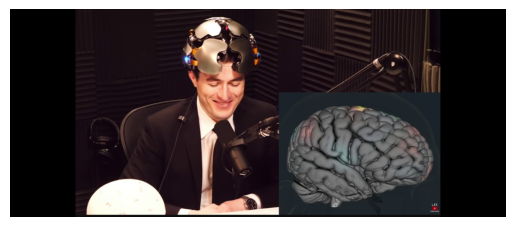

1

In [54]:
index += 1
index %= len(laughter_all_frames)
plt.imshow(cv2.cvtColor(laughter_all_frames[index], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
index 

In [55]:
laughter_all_frames[index].shape

(1440, 3440, 3)

In [17]:
lex_brain_regions = {"lex_brain_y_t":600}
lex_brain_regions["lex_brain_y_b"] = 1400
lex_brain_regions["lex_brain_x_l"] = 1900
lex_brain_regions["lex_brain_x_r"] = 2950

In [18]:
lex_human_regions = {}
lex_human_regions["lex_human_y_t"] = 0
lex_human_regions["lex_human_y_b"] = 1440
lex_human_regions["lex_human_x_l"] = 500
lex_human_regions["lex_human_x_r"] = 1800


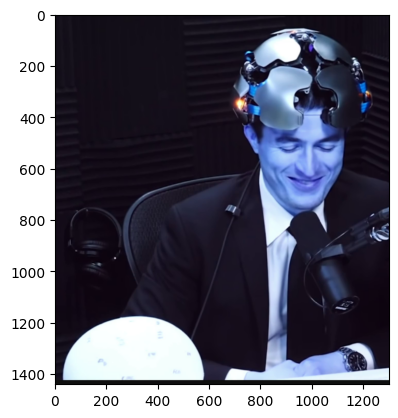

In [19]:
plt.imshow(laughter_all_frames[0][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])

In [20]:
# Collect Lex Human Laughter Only
lex_human_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Lex Only Laughter Frames...", ascii="░▒▓█"):
    lex_human_laughter_only.append(laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_laughter_only_np = np.array(lex_human_laughter_only)

Extracting Lex Only Laughter Frames...: 100%|██████████| 251/251 [00:00<00:00, 1497539.55it/s]


In [44]:
# np.save('../data/laughter-only/lex_human_laughter_only.npy', lex_human_laughter_only_np)

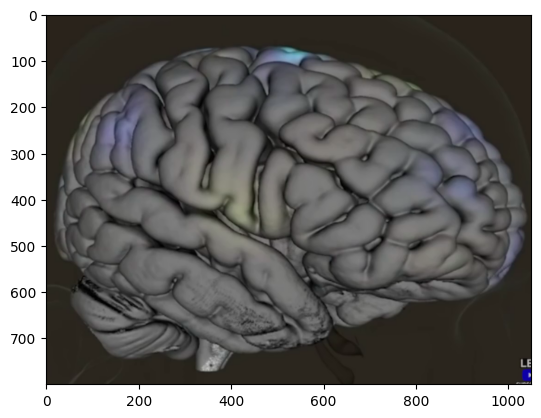

In [21]:
plt.imshow(laughter_all_frames[0][600:1400, 1900:2950, :])

In [22]:
# Collect Lex Brain Laughter Only
lex_brain_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Brain Only Laughter Frames...", ascii="░▒▓█"):
    lex_brain_laughter_only.append(laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_laughter_only_np = np.array(lex_brain_laughter_only)


Extracting Brain Only Laughter Frames...: 100%|██████████| 251/251 [00:00<00:00, 1287005.26it/s]


In [48]:

# np.save("../data/laughter-only/lex_brain_laughter_only.npy", lex_brain_laughter_only_np)

## Non-Laughter Samples

### Sample Extraction

In [ ]:
video_file_path_non_laughter_train

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

In [ ]:
cap = cv2.VideoCapture(video_file_path_non_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds
total_frames

In [ ]:
non_laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    non_laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

In [ ]:
# np.save('../data/non-laughter/non_laughter_all_frames.npy', np.array(non_laughter_all_frames))

In [ ]:
len(laughter_all_frames)

In [ ]:
len(non_laughter_all_frames)

In [ ]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
# np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


### Extracting the Neural Data Frame (Non-Laughter)

In [ ]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
# np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


## Test Non-Laughter

In [ ]:
video_file_path = "../data/lex-attempting-not-to-laugh-no-audible-laughter.mp4"

In [ ]:
cap = cv2.VideoCapture(video_file_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
non_laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    non_laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

In [ ]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
# np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
# np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


In [ ]:
# Creating Brain Dataset Non-Laughter
f_dir = '../data/non-laughter/test/brain/'
for index in tqdm(range(len(lex_brain_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
    f_name = f"lex_brain_non_laughter_test_{index}.png"
    PIL_Image.fromarray(lex_brain_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

In [ ]:
# Creating Human Dataset Non-Laughter
f_dir = '../data/non-laughter/test/human/'
for index in tqdm(range(len(lex_human_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
    f_name = f"lex_human_non_laughter_test_{index}.png"
    PIL_Image.fromarray(lex_human_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

## Creating Datasets

In [ ]:
# # Creating Brain Dataset Laughter
# f_dir = '../data/laughter-only/brain/'
# for index in tqdm(range(len(lex_brain_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_brain_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 251/251 [00:21<00:00, 11.42it/s]


In [ ]:
# # Creating Brain Dataset Non-Laughter
# f_dir = '../data/non-laughter/brain/'
# for index in tqdm(range(len(lex_brain_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_brain_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

In [ ]:
# # Creating Human Dataset Laughter
# f_dir = '../data/laughter-only/human/'
# for index in tqdm(range(len(lex_human_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_human_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 251/251 [00:38<00:00,  6.53it/s]


In [ ]:
# # Creating Human Dataset Non-Laughter
# f_dir = '../data/non-laughter/human/'
# for index in tqdm(range(len(lex_human_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_human_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

In [ ]:
# Collecting audio lecture segments
# smile_data_dir = '../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/'
# non_laughter_audio_segment_file_paths = glob(smile_data_dir + "*_*_*")
# single_underscore_file_candidates = glob(smile_data_dir + '*_*')
# laughter_only_audio_segment_file_paths = [file for file in single_underscore_file_candidates if os.path.basename(file).count('_') == 1]

In [ ]:
# len(laughter_only_audio_segment_file_paths)

In [ ]:
# len(non_laughter_audio_segment_file_paths)

In [ ]:
destination_folder_laughter = '../data/modalities/audio/laughter-only-mp4'
destination_folder_non_laughter = '../data/modalities/audio/non-laughter-mp4'

In [ ]:
# for file_path in tqdm(non_laughter_audio_segment_file_paths, desc="Copying non-laughter audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_non_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     print(f"Copied {file_path} to {destination_path}")

In [ ]:
# for file_path in tqdm(laughter_only_audio_segment_file_paths, desc="Copying laughter only audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     # print(f"Copied {file_path} to {destination_path}")

## Facial Emotion Expert

In [ ]:
lex_human_laughter_only_gray_np_img = cv2.cvtColor(lex_human_laughter_only_np[0], cv2.COLOR_BGR2GRAY)
plt.imshow(lex_human_laughter_only_gray_np_img, cmap="gray")
lex_human_laughter_only_gray_np_img.shape
plt.axis('off')
plt.show()
# plt.imshow(lex_human_laughter_only_gray_np[0])

### Extract Face Mesh

In [ ]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def extract_landmarks(image_path):
    # Read and process image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    # Extract landmarks
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = landmark.x, landmark.y  # Normalized (0 to 1)
                landmarks.append([x, y])

    if len(landmarks) == 468:  # Ensure full face mesh is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if face not detected

# Example usage
landmark_vector = extract_landmarks("laughter.jpg")
print(landmark_vector.shape)  # Should be (936,) if all landmarks are found


### Facial Emotion Dataset

In [ ]:
# Custom dataset class
class LaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no face detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = LaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Facial Emotion Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LaughterCNN(nn.Module):
    def __init__(self):
        super(LaughterCNN, self).__init__()
        self.fc1 = nn.Linear(936, 256)  # 468 x 2 = 936 input features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterCNN()


### Facial Emotion Predictions

In [ ]:
def predict_laughter(image_path, model):
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        return "No Face Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter("test_laugh.jpg", model))


## Kernel Neural Image Expert

#### Data Examples

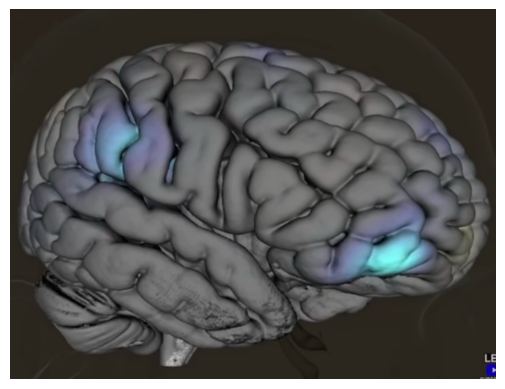

Number of Examples of Laughter: 279


In [275]:
plt.imshow(lex_brain_laughter_only_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Laughter: {len(lex_brain_laughter_only_np)}")

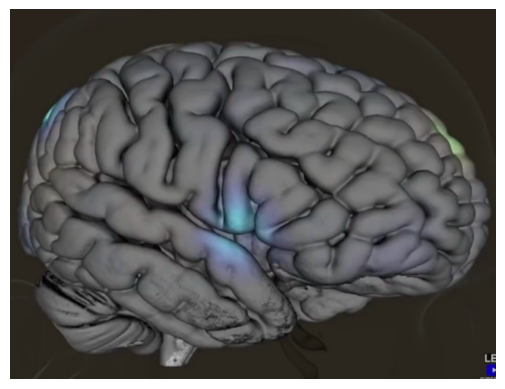

Number of Examples of Non-Laughter: 339


(800, 1050, 3)

In [276]:
plt.imshow(lex_brain_non_laughter_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Non-Laughter: {len(lex_brain_non_laughter_np)}")
lex_brain_non_laughter_np[0].shape

In [47]:
index = 0

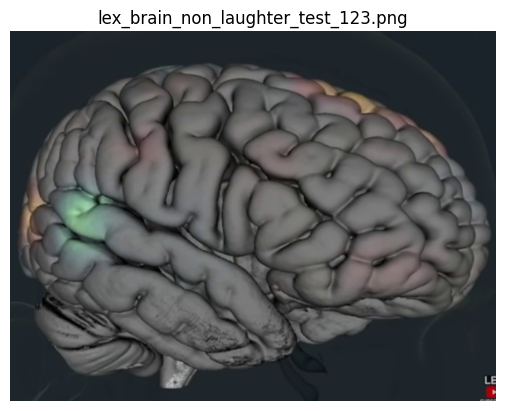

Predicted class: 1, Ground truth: 0


In [54]:
# Testing the trained model

# Load and preprocess the image
# image_path = "../data/lex-brain-laughter-01-27.png"  # Path to your uploaded image
# image_path = "../data/lex-brain-baseline-00-37.png"  # Path to your uploaded image

test_image_path = glob('../data/test/brain/0_non-laughter/' + "*.png")

# image_path = "../data/lex-non-laughter.png"  # Path to your uploaded image
image_path  = test_image_path[index]

image = PIL_Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
plt.imshow(cv2.imread(image_path))
plt.title(f"{os.path.basename(image_path)}")
plt.axis('off')
plt.show()
index+=1 
index%=len(test_image_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=neural_data_model.brain_modality_mean, std=neural_data_model.brain_modality_std)  # Normalize (if needed)
])

# Assuming 'image_path' is the path to your image and 'label' is the associated label
# image_path = "path_to_your_image.jpg"
label = 0  # for example, 1 for 'Laughter', 0 for 'Non-Laughter'

# Create dataset
dataset = SingleImageDataset(image_path=image_path, label=label, transform=transform)

# Create DataLoader (batch_size=1 because it's a single image)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate through the DataLoader (although there is only one batch in this case)
# for images, labels in dataloader:
    # print(images.shape)  # e.g., torch.Size([1, 3, 224, 224]) if using transform.Resize((224, 224))
    # print(labels)        # e.g., tensor([1])

# Assuming 'neural_data_model' is your model
neural_data_model.eval()

# Move model to the same device as the data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_data_model.to(device)

# Iterate through the DataLoader
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = neural_data_model(images)
        _, predicted = torch.max(outputs, 1)
        prediction = predicted.item()

        # Print the result
        print(f"Predicted class: {prediction}, Ground truth: {labels.item()}")


In [56]:
dataset = tv_datasets.ImageFolder(root='../data/test/brain/', transform=neural_data_model.transform)

In [57]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
neural_data_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_  = neural_data_model.to(device)
predictions = []
total = 0
correct = 0
all_labels = []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        all_labels.append(labels.cpu().numpy())
        # Forward pass
        
        
        outputs = neural_data_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

all_labels = np.concatenate(all_labels, axis=0)
predictions = np.concatenate(predictions, axis=0)


Test Accuracy: 78.19%


In [58]:
all_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [60]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

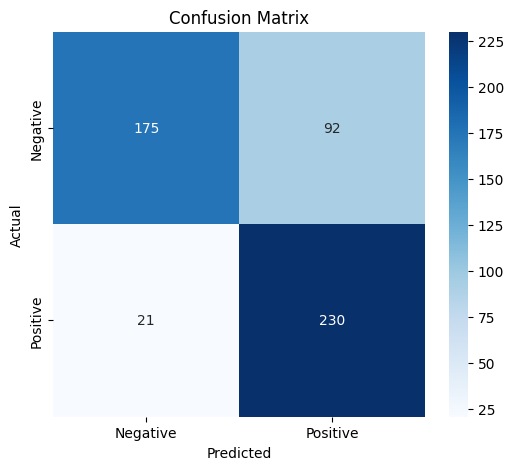

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       267
           1       0.71      0.92      0.80       251

    accuracy                           0.78       518
   macro avg       0.80      0.79      0.78       518
weighted avg       0.81      0.78      0.78       518


Other Metrics:
Accuracy: 0.7819
Precision: 0.7143
Recall: 0.9163
F1-Score: 0.8028
ROC AUC: 0.7859


In [ ]:
y_true = all_labels  # True labels
y_pred = predictions  # Predicted labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate classification report (includes precision, recall, f1-score, support)
report = classification_report(y_true, y_pred)

# Calculate other metrics (if needed)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print classification report and other metrics
print("Classification Report:")
print(report)

print("\nOther Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


##### Training The Neural Model

In [35]:
# Computing the Mean and Variance to Normalize the data:

# Load your dataset
dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=transforms.ToTensor())

# Create a DataLoader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize variables to compute the mean and std
brain_modality_mean = 0.0
brain_modality_std = 0.0
num_batches = 0

# Iterate over the dataset to compute mean and std
for images, _ in dataloader:
    batch_samples = images.size(0)  # Get the number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten the images
    brain_modality_mean += images.mean(2).sum(0)  # Sum the mean of each image channel
    brain_modality_std += images.std(2).sum(0)    # Sum the std of each image channel
    num_batches += 1

brain_modality_mean /= num_batches  # Average mean over all batches
brain_modality_std /= num_batches    # Average std over all batches

print("Mean:", brain_modality_mean)
print("Std:", brain_modality_std)


Mean: tensor([17.6743, 17.4406, 17.1653])
Std: tensor([7.7531, 8.4884, 9.5815])


In [36]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=brain_modality_mean, std=brain_modality_std)  # Normalize pixel values
])


In [37]:
# Initialize model
neuralModel = NeuralDataExpert().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neuralModel.parameters(), lr=0.001)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load dataset (Assuming laughter and non-laughter images are in separate folders)
neuralModel = NeuralDataExpert().to(device)
dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=neuralModel.transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [39]:

# Training loop
epochs = 10
for epoch in tqdm(range(epochs), desc="Training...", ascii="░▒▓█"):
    neuralModel.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = neuralModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training...:  10%|█░░░░░░░░░| 1/10 [00:09<01:25,  9.53s/it]

Epoch [1/10], Loss: 0.7714


Training...:  20%|██░░░░░░░░| 2/10 [00:18<01:14,  9.26s/it]

Epoch [2/10], Loss: 0.7744


Training...:  30%|███░░░░░░░| 3/10 [00:27<01:03,  9.14s/it]

Epoch [3/10], Loss: 0.7679


Training...:  40%|████░░░░░░| 4/10 [00:36<00:54,  9.08s/it]

Epoch [4/10], Loss: 0.7703


Training...:  50%|█████░░░░░| 5/10 [00:45<00:45,  9.06s/it]

Epoch [5/10], Loss: 0.7694


Training...:  60%|██████░░░░| 6/10 [00:54<00:36,  9.13s/it]

Epoch [6/10], Loss: 0.7704


Training...:  70%|███████░░░| 7/10 [01:03<00:27,  9.06s/it]

Epoch [7/10], Loss: 0.7670


Training...:  70%|███████░░░| 7/10 [01:08<00:29,  9.83s/it]


KeyboardInterrupt: 

In [40]:
neuralModel = neural_data_model

In [41]:
# Evaluation
neuralModel.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = neuralModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


In [ ]:
# save_model(neuralModel, "../models/neural_image_classifier_model.pth")

## Audio Laughter Expert

### Define Audio Dataloader

### Build MFCC Dataset

### Train Model

In [46]:
audio_data_path

'../data/modalities/audio/'

In [47]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = AudioClassifier(n_mfcc=40, max_len=96).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [48]:
# Define the dataset
dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)

# Split the dataset into training and testing sets (80% for training and 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [49]:
# Set number of training epochs
num_epochs = 10  # You can adjust this

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
# dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)
# train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = AudioClassifier(n_mfcc=40, max_len=96).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for mfccs, labels in tqdm(train_loader, desc="Training...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Normalize MFCCs
        mfccs = (mfccs - mfccs.mean()) / mfccs.std()

        # Forward pass
        outputs = model(mfccs)  # Ensure correct input shape

        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1).float())

        # Backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training...:   5%|▒░░░░░░░░░| 11/216 [00:03<01:08,  2.98it/s]


KeyboardInterrupt: 

### Make Predictions

In [50]:
model = audio_laughter_classifier_model

In [51]:
# Set model to evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for mfccs, labels in tqdm(test_loader, desc="Calculating Predictions...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)
        
        # Normalize MFCCs
        mfccs = (mfccs - mfccs.mean()) / mfccs.std()

        # # Ensure MFCCs are correctly shaped
        # mfccs = mfccs.unsqueeze(1)  # Add channel dimension if missing
        
        # Forward pass
        outputs = model(mfccs)

        # Convert model outputs to binary predictions (0 or 1)
        predicted = (outputs >= 0.5).float()  # Sigmoid outputs >= 0.5 -> 1, else 0
        
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()  # Compare predictions

# Compute accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Calculating Predictions...: 100%|██████████| 54/54 [00:13<00:00,  4.06it/s]

Test Accuracy: 99.77%


In [ ]:
# Example usage:
# save_model(model, "../models/audio_classifier_model.pth")

In [ ]:
audio_laughter_classifier_model = load_torch_model(audio_laughter_classifier_model_path, AudioClassifier)

##### Model Evaluation

In [53]:

# Load the audio file (assuming you have a .wav file)
audio_file = "../data/kernel-brain-data-audio.wav"
audio_data, fs = librosa.load(audio_file, sr=None)  # Load audio with original sampling rate

# Define the parameters for MFCC extraction
n_mfcc = 40  # Number of MFCCs
hop_length = 512  # Hop length (frame shift)
n_fft = 2048  # FFT window size

# Compute MFCC features
mfcc = librosa.feature.mfcc(y=audio_data, sr=fs, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

# Ensure that we have exactly 40 MFCCs and 96 frames per second
# Check if mfcc has the right number of frames per second (96 frames per second)
# Librosa will give us variable frames, so we need to pad or truncate if necessary.

target_frames = 96  # Target number of frames per second

# Adjust number of frames to match 96 frames per second (if necessary)
frames_per_second = mfcc.shape[1] / (len(audio_data) / fs)
desired_length = target_frames * (len(audio_data) // fs)

# If we need to truncate or pad
if mfcc.shape[1] > desired_length:
    mfcc = mfcc[:, :desired_length]  # Truncate
elif mfcc.shape[1] < desired_length:
    pad_width = desired_length - mfcc.shape[1]
    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')  # Pad with zeros

# Verify the shape
print(f"MFCC shape: {mfcc.shape}")  # Expected shape: (40, 96*length_in_seconds)

# Now, feed the data to the model 1 second at a time
audio_chunks = []

for i in range(0, mfcc.shape[1], target_frames):
    chunk = mfcc[:, i:i+target_frames]  # Get 1-second chunk of MFCCs (40 x 96)
    
    # Convert to a PyTorch tensor
    chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 40, 96)
    
    # Store the chunk for feeding into the model
    audio_chunks.append(chunk_tensor)

# Now, you can use `audio_chunks` to feed into the model one chunk at a time


MFCC shape: (40, 14016)


In [ ]:
len(audio_chunks)

In [54]:
classifications = []
for chunk in tqdm(range(len(audio_chunks)), desc="Classifying Audio...", ascii="░▒▓█"):
    pred = audio_laughter_classifier_model(audio_chunks[chunk].to(device))
    classifications.append(pred)

Classifying Audio...: 100%|██████████| 146/146 [00:00<00:00, 4265.47it/s]


In [55]:
classifications = [1 if classifications[index][0] == 1 else 0 for index in range(len(classifications))]

In [56]:
len(classifications)

146

In [57]:
size = 146
ground_truth = [7, 12, 63, 66, 77, 85, 86, 87, 88, 89, 90, 106, 107, 108, 109, 110]
# Create a zero array
ground_truth_bin = np.zeros(size, dtype=int)

# Set specified indices to 1
np.put(ground_truth_bin , ground_truth, 1)

In [58]:
np.array(classifications).__len__()

146

In [59]:
print(f"Accuracy of audio classifier: {accuracy_score(ground_truth_bin, classifications):.5f}")

Accuracy of audio classifier: 0.36301


##### Verification of Audio Labels

1. Use a verified zero-shot-classifier to predict the presence of laughter in the segments of data to verify the labels are correct. 
2. Move the data if necessary
3. Retrain the audio classifier
4. Examine the results

In [68]:
audio_data_path

'../data/modalities/audio/'

In [69]:
zero_shot_classifier = pipeline(
    task="zero-shot-audio-classification",
    model="laion/clap-htsat-unfused")

candidate_labels = ['laughter', 'non-laughter']

Device set to use cuda:0


In [ ]:
laughter_only_file_paths = glob(audio_data_path + "/laughter-only/*.wav")
non_laughter_file_paths = glob(audio_data_path + "/non-laughter/*.wav")


In [77]:
zero_shot_classifier.device

device(type='cuda', index=0)

In [79]:
laughter_predictions = []
for audio_file in tqdm(laughter_only_file_paths, desc="Zero-shot-classification of laughter only files...", ascii="░▒▓█"):
    data, sr = librosa.load(audio_file)
    prediction = zero_shot_classifier(data, candidate_labels = candidate_labels)
    laughter_predictions.append(prediction)

Zero-shot-classification of laughter only files...:   0%|░░░░░░░░░░| 7/2383 [00:00<02:04, 19.14it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot-classification of laughter only files...: 100%|██████████| 2383/2383 [02:02<00:00, 19.52it/s]


In [105]:
laughter_predictions_text = [laughter_predictions[index][0]['label'] for index in range(len(laughter_predictions))]

In [106]:
laughter_classifications = []
for pred in laughter_predictions_text:
    if pred == "laughter":
        laughter_classifications.append(1)
    else:
        laughter_classifications.append(0)
laughter_classifications = np.array(laughter_classifications)

In [107]:
laughter_classifications

array([0, 1, 0, ..., 0, 0, 0])

In [80]:
non_laughter_predictions = []
for audio_file in tqdm(non_laughter_file_paths, desc="Zero-shot-classification of non-laughter files...", ascii="░▒▓█"):
    data, sr = librosa.load(audio_file)
    prediction = zero_shot_classifier(data, candidate_labels = candidate_labels)
    non_laughter_predictions.append(prediction)

Zero-shot-classification of non-laughter files...: 100%|██████████| 1936/1936 [01:36<00:00, 20.15it/s]


In [ ]:
non_laughter_predictions

In [108]:
non_laughter_predictions_text = [non_laughter_predictions[index][0]['label'] for index in range(len(non_laughter_predictions))]
non_laughter_classifications = []
for pred in non_laughter_predictions_text:
    if pred == "laughter":
        non_laughter_classifications.append(1)
    else:
        non_laughter_classifications.append(0)
non_laughter_classifications = np.array(non_laughter_classifications)

In [117]:
predictions = np.concatenate((laughter_classifications, non_laughter_classifications), axis=0)

In [123]:
laughter_truth = np.ones(len(laughter_only_file_paths))
# non_laughter_truth = np.zeros(len(non_laughter_file_paths))
# ground_truth = np.concatenate((laughter_truth, non_laughter_truth), axis=0)
ground_truth = laughter_truth
ground_truth

array([1., 1., 1., ..., 1., 1., 1.])

In [124]:
discrepency = accuracy_score(ground_truth, laughter_classifications)

In [126]:
len(laughter_classifications)

2383

In [130]:
laughter_classifications

array([0, 1, 0, ..., 0, 0, 0])

In [125]:
discrepency

0.08518673940411246

##### Classifying using the Clipped Audio

In [ ]:
# Smile Dataset is not useful for classification without preprocessing and labeling

In [71]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dataset
dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)

# Define the DataLoader
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False)


In [74]:
correct = 0
total = 0

with torch.no_grad():
    for mfccs, labels in tqdm(dataLoader, desc="Zero-shot-classification of Audio...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)
        print(f"{mfccs.shape}")
        
        # Classify
        outputs = zero_shot_classifier(mfccs, candidate_labels = candidate_labels)
        
        predicted = (outputs >= 0.5).float() # Sigmoid outputs >= 0.5 -> 1, else 0
        
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item() # compare predictions
        
# Compute accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Zero-shot-classification of Audio...:   0%|░░░░░░░░░░| 0/4319 [00:00<?, ?it/s]

torch.Size([1, 1, 40, 96])


TypeError: We expect a numpy ndarray as input

In [ ]:
audio_laughter_classifier_model.eval()
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for mfccs, labels in tqdm(test_loader, desc="Calculating Predictions...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)
        
        # Normalize MFCCs
        mfccs = (mfccs - mfccs.mean()) / mfccs.std()

        # # Ensure MFCCs are correctly shaped
        # mfccs = mfccs.unsqueeze(1)  # Add channel dimension if missing

        print(f"{mfccs.shape}")
        
        # Forward pass
        outputs = zero_shot_classifier(mfccs, candidate_labels = candidate_labels)

        # Convert model outputs to binary predictions (0 or 1)
        predicted = (outputs >= 0.5).float()  # Sigmoid outputs >= 0.5 -> 1, else 0
        
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()  # Compare predictions

# Compute accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

##### Visualization of Audio Classification Results

In [60]:
index = 0

In [ ]:
# Load and play the audio
audio_path = "../data/kernel-brain-data-audio.wav"
wav_file = wave.open(audio_path, 'rb')
fs = wav_file.getframerate()
audio_data = np.frombuffer(wav_file.readframes(wav_file.getnframes()), dtype=np.int16)

In [ ]:
seconds = int(wav_file.getnframes() / fs)

In [ ]:
audio_data

In [ ]:
import ipywidgets as widgets
# Create text widget
text_widget = widgets.Label(value="Starting...")

# Function to update text dynamically while playing audio
def play_audio_with_text():
    sd.play(audio_data, samplerate=fs*2)  # Play the audio

    for sec in range(min(seconds, int(wav_file.getnframes() / fs))):
        if ground_truth_bin[sec] == 1: # implementing human-labeling rather than the classifier
        # pred = audio_laughter_classifier_model(audio_chunks[sec].to(device))
        # if  pred[0][0] == 1:
            text_widget.value = f"Time: {sec}s \nClassification: Laughter"
        else:
            text_widget.value = f""
        time.sleep(1)  # Wait for 1 second

    sd.stop()  # Stop playback when done

# Display text widget
display(text_widget)

# Start playback and text update
play_audio_with_text()


## Body Pose Expert

### Extract Pose Body Features

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_image)

    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            x, y, visibility = landmark.x, landmark.y, landmark.visibility
            landmarks.append([x, y, visibility])

    if len(landmarks) == 33:  # Ensure full pose is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if pose not detected

# Example usage
pose_vector = extract_pose_landmarks("laughter_pose.jpg")
print(pose_vector.shape)  # Should be (99,) if all landmarks are found (33 x 3)


### Laughter Pose CNN

In [ ]:
import torch
import torch.nn as nn

class LaughterPoseCNN(nn.Module):
    def __init__(self):
        super(LaughterPoseCNN, self).__init__()
        self.fc1 = nn.Linear(99, 128)  # 33 x 3 = 99 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterPoseCNN()


### Laughter Pose Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PoseLaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_pose_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no pose detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = PoseLaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Training Laughter Pose Model

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch in dataloader:
        if batch is None:
            continue  # Skip invalid samples
        
        landmarks, labels = batch
        labels = labels.unsqueeze(1)  # Reshape for BCELoss

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

print("Training complete!")


### Making Model Predictions

In [ ]:
def predict_laughter_from_pose(image_path, model):
    landmarks = extract_pose_landmarks(image_path)
    if landmarks is None:
        return "No Pose Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter_from_pose("test_laughter_pose.jpg", model))


## Training a Mixture of Experts Model Example

The MoE takes 1 frame of data and 1 second of audio for classification

In [62]:
# Assuming you have your individual datasets ready for each modality
neuralModel = NeuralDataExpert().to(device)

audio_dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)
neural_dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=neuralModel.transform)
# image_dataset = ImageDataset(root_dir=image_data_path)  # Modify this for your image dataset
# other_modalities_dataset = OtherModalitiesDataset(root_dir=other_modalities_data_path)  # Modify as needed


/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
# Load dataset (Assuming laughter and non-laughter images are in separate folders)
neuralModel = NeuralDataExpert().to(device)
dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=neuralModel.transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:

# Split datasets (as you did before for audio)
train_size = int(0.8 * len(audio_dataset))
test_size = len(audio_dataset) - train_size
train_audio_dataset, test_audio_dataset = random_split(audio_dataset, [train_size, test_size])
train_image_dataset, test_image_dataset = random_split(image_dataset, [train_size, test_size])
train_other_modalities_dataset, test_other_modalities_dataset = random_split(other_modalities_dataset, [train_size, test_size])

# Create the multi-modal dataset for training and testing
train_multimodal_dataset = MultiModalDataset(
    audio_dataset=train_audio_dataset,
    image_dataset=train_image_dataset,
    other_modalities_dataset=train_other_modalities_dataset
)
test_multimodal_dataset = MultiModalDataset(
    audio_dataset=test_audio_dataset,
    image_dataset=test_image_dataset,
    other_modalities_dataset=test_other_modalities_dataset
)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_multimodal_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_multimodal_dataset, batch_size=16, shuffle=False)


In [ ]:
# Example usage
model = MixtureOfExperts()
# audio_data = torch.randn(1, 256)  # Example audio data
facial_emotion_data = torch.randn(1, 256)  # Example facial emotion data
body_pose_data = torch.randn(1, 256)  # Example body pose data
# neural_data = torch.randn(1, 256)  # Example neural data

# Make a prediction
prediction = model(audio_data, facial_emotion_data, body_pose_data, neural_data)
print(f"Predicted output: {prediction}")


In [ ]:
# Preparing training and validation data
import numpy as np

# Load or generate random data (replace with actual data loading)
num_samples = 1000  # Adjust based on dataset size
audio_features = np.random.randn(num_samples, 256)
facial_features = np.random.randn(num_samples, 256)
body_features = np.random.randn(num_samples, 256)
neural_features = np.random.randn(num_samples, 256)
labels = np.random.randint(0, 2, size=(num_samples, 1))  # Binary labels

# Split into training and validation sets
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

dataset = LaughterDataset(audio_features, facial_features, body_features, neural_features, labels)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Defining the training loop
import torch.optim as optim

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MixtureOfExperts().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for audio, facial, body, neural, label in train_loader:
            audio, facial, body, neural, label = (
                audio.to(device),
                facial.to(device),
                body.to(device),
                neural.to(device),
                label.to(device),
            )

            optimizer.zero_grad()
            output = model(audio, facial, body, neural)
            loss = criterion(output, label)  # Compute loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for audio, facial, body, neural, label in val_loader:
                audio, facial, body, neural, label = (
                    audio.to(device),
                    facial.to(device),
                    body.to(device),
                    neural.to(device),
                    label.to(device),
                )

                output = model(audio, facial, body, neural)
                val_loss += criterion(output, label).item()
                predicted = (output > 0.5).float()  # Convert probability to class (0 or 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

# Train for 20 epochs
train_model(model, train_loader, val_loader, epochs=20)


In [ ]:
# Saving the model
# torch.save(model.state_dict(), "moe_laughter_model.pth")

# Loading the model
# model = MixtureOfExperts()
# model.load_state_dict(torch.load("moe_laughter_model.pth"))
# model.to(device)
# model.eval()


In [ ]:
# Making Predictions
# Example input
new_audio = torch.randn(1, 256).to(device)
new_facial = torch.randn(1, 256).to(device)
new_body = torch.randn(1, 256).to(device)
new_neural = torch.randn(1, 256).to(device)

# Get model prediction
with torch.no_grad():
    prediction = model(new_audio, new_facial, new_body, new_neural)
    predicted_label = (prediction > 0.5).float().item()  # Convert to class label

print(f"Predicted label: {predicted_label}")  # 1 for laughter, 0 for no laughter


## Data Representation

    Audio: Convert audio signals into spectrograms or MFCCs (Mel-Frequency Cepstral Coefficients).
    Facial Emotion: Use a facial recognition system (like OpenCV or Dlib) to extract facial landmarks and classify emotional states.
    Body Pose: Use a pose estimation model (like OpenPose or MediaPipe) to extract keypoints of the body.
    Neural Data: Normalize brain activity (e.g., fMRI, EEG) to a standard scale.

2. Model Architecture

The core idea is to create a multi-encoder architecture with modality-specific subnetworks and a fusion layer. Here's how to structure it:
Step 1: Modality-Specific Encoders

Create separate neural networks (like CNNs, RNNs, or Transformers) for each modality. Here's how:

    Audio Encoder: Use a 1D CNN or RNN to process audio features like spectrograms.
    Facial Emotion Encoder: Use a CNN (ResNet, VGG) to process facial emotion features extracted from images.
    Body Pose Encoder: Use a CNN or RNN to process body pose keypoints.
    Neural Data Encoder: Use a simple MLP (Multi-layer Perceptron) or RNN to process neural data like EEG or fMRI.

In [ ]:
non_laughter_audio_data, non_laughter_sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=non_laughter_audio_data, rate=non_laughter_sample_rate)


In [ ]:

laughter_only_audio_data, laughter_only_sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=laughter_only_audio_data, rate=laughter_only_sample_rate)